In [1]:
import proposal as pp
import numpy as np
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from helper_functions_multi import get_angle_deviation
import os
from crflux.models import H3a_polygonato
import crflux.models as crf
from MCEq.core import MCEqRun
import scipy.integrate as integrate
from scipy.optimize import fmin, minimize

In [2]:
data_dir = 'data/atmospheric_flux_deflection/'
os.system('mkdir -p {}'.format(data_dir))

plot_dir = 'plots/atmospheric_flux_deflection/'
os.system('mkdir -p {}'.format(plot_dir))

save_plot = True

No handles with labels found to put in legend.


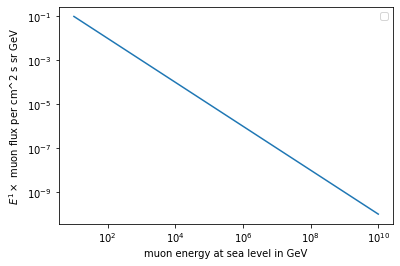

In [8]:
# Gaisser 1990

def muon_flux_gaisser(E_sea, E_top=None, theta=0):
    '''
        Parameters
        ----------
        E_sea: muon energy at sea level
        E_top: muon energy at the top of the atmosphere
        theta: muon zenith angle
        A_G: scale factory
    '''
    A_G = 0.14
    gamma = 2.7
    E_top = E_sea # at high energies
    epsilon_pi = 115/1.1 # GeV
    epsilon_kaon = 810/1.1 # GeV
    B_G = 0.054
    return A_G * E_sea**(-gamma) * ((1/(1 + E_top * np.cos(theta)/epsilon_pi)) + (B_G / (1 + E_top * np.cos(theta)/epsilon_kaon)))

muon_flux_gaisser_lambda = lambda E_sea, theta: 0.14 * E_sea**(-2.7) * ((1/(1 + E_sea * np.cos(theta)/115/1.1)) + (0.054 / (1 + E_sea * np.cos(theta)/810/1.1)))


# TIG model
def TIG(energies):
    E_list = []
    for E in energies:
        if E < 5e6:
            E_list.append(1.7e4 * E**(-2.7))
        elif E >= 5e6:
            E_list.append(174e4 * E**(-3))
    return np.array(E_list)

# https://arxiv.org/pdf/1907.00640.pdf
def muon_flux_icecube(E_mu):
    '''
        Parameters
        ----------
        E_mu: muon energy in GeV
    '''
    gamma = 3.74
    return 9e-17 * (E_mu / 50e3)**(-gamma)

    
weighting = 1
energies = np.logspace(1, 10, 10)
#plt.plot(energies, muon_flux_gaisser(energies) * energies**weighting, label='Gaisser')
#plt.plot(energies, TIG(energies) * 1e-4 * energies**weighting, label='TIG')
#plt.plot(energies, H3a_polygonato().total_flux(energies) * 1e-4 * energies**weighting, label='H3a crflux')
#energies = np.logspace(4, 6, 10)
#plt.plot(energies, muon_flux_icecube(energies) * energies**weighting, label='IceCube fit')
plt.plot(energies, 1/energies)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('muon energy at sea level in GeV')
plt.ylabel(r'$E^{} \times$ muon flux per cm^2 s sr GeV'.format(weighting))
plt.legend()

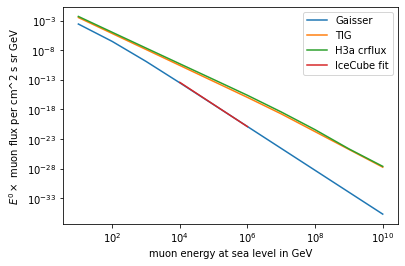

In [10]:
weighting = 0
energies = np.logspace(1, 10, 10)
plt.plot(energies, muon_flux_gaisser(energies) * energies**weighting, label='Gaisser')
plt.plot(energies, TIG(energies) * 1e-4 * energies**weighting, label='TIG')
plt.plot(energies, H3a_polygonato().total_flux(energies) * 1e-4 * energies**weighting, label='H3a crflux')
energies = np.logspace(4, 6, 10)
plt.plot(energies, muon_flux_icecube(energies) * energies**weighting, label='IceCube fit')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('muon energy at sea level in GeV')
plt.ylabel(r'$E^{} \times$ muon flux per cm^2 s sr GeV'.format(weighting))
plt.legend()

In [ ]:
mceq_90 = MCEqRun(interaction_model='SIBYLL23C', primary_model=(crf.HillasGaisser2012, 'H3a'), theta_deg=90.)

In [ ]:
# h_grid = np.linspace(50 * 1e3 * 1e2, 0) # altitudes from 50km to 0cm
# X_grid = mceq.density_model.h2X(h_grid)
# mceq.solve(int_grid=X_grid)
mceq_90.solve()

In [ ]:
mceq_0 = MCEqRun(interaction_model='SIBYLL23C', primary_model=(crf.HillasGaisser2012, 'H3a'), theta_deg=0.)
mceq_0.solve()

In [ ]:
mceq_60 = MCEqRun(interaction_model='SIBYLL23C', primary_model=(crf.HillasGaisser2012, 'H3a'), theta_deg=60.)
mceq_60.solve()

In [ ]:
e_bin_mids = np.array([])
for i in range(len(mceq_0.e_bins))[:-1]:
    e_bin_mids = np.append(e_bin_mids, mceq_0.e_bins[i] + (mceq_0.e_bins[i+1] - mceq_0.e_bins[i])/2)

In [ ]:
# MCEq
plt.plot(e_bin_mids, mceq_90.get_solution('mu-', mag=3) + mceq_90.get_solution('mu+', mag=3), label='MCEq H3a 90°')
plt.plot(e_bin_mids, mceq_60.get_solution('mu-', mag=3) + mceq_60.get_solution('mu+', mag=3), label='MCEq H3a 60°')
plt.plot(e_bin_mids, mceq_0.get_solution('mu-', mag=3) + mceq_0.get_solution('mu+', mag=3), label='MCEq H3a 0°')
# plt.plot(e_bin_mids, (mceq_0.get_solution('mu-') + mceq_0.get_solution('mu+')) * e_bin_mids**3, label='MCEq H3a 0°')

# gaisser
energies = np.logspace(1, 10, 10)
plt.plot(energies, muon_flux_gaisser(energies, theta=0.) * energies**3, label='Gaisser 0°')
plt.plot(energies, muon_flux_gaisser(energies, theta=np.deg2rad(60.)) * energies**3, label='Gaisser 60°')
# icecube fit
energies = np.logspace(4, 6, 10)
plt.plot(energies, muon_flux_icecube(energies) * energies**3, label='IceCube fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('energy in GeV')
plt.ylabel(r'$E^3 \times \Phi$ ')
plt.xlim(None, 1e9)
plt.ylim(1e-8, 1)
plt.legend()
plt.title('mu+ and mu-')

In [ ]:
from sklearn import preprocessing
plt.plot(e_bin_mids, mceq_0.get_solution('mu-') + mceq_0.get_solution('mu+'), label='MCEq')
plt.plot(e_bin_mids, muon_flux_gaisser(e_bin_mids), label='Gaisser')
plt.plot(e_bin_mids, preprocessing.normalize([mceq_0.get_solution('mu-') + mceq_0.get_solution('mu+')])[0], label='normalized')
plt.yscale('log')
plt.xscale('log')
plt.legend()
print(np.sum(preprocessing.normalize([mceq_0.get_solution('mu-') + mceq_0.get_solution('mu+')])[0]))
print(np.sum(preprocessing.normalize([muon_flux_gaisser(e_bin_mids)])))

In [ ]:
mceq_0.get_solution('mu-') + mceq_0.get_solution('mu+')

# sample energies from gaisser 

In [ ]:
def sample_from_gaisser(n_events, e_min_log, e_max_log, p_max, weighting=None, rnd_seed=33):
    rnd = np.random.RandomState(rnd_seed)
    sample = []
    if weighting == None:
        while len(sample) < n_events:
            p = rnd.random.uniform(0, p_max)
            e = rnd.uniform(e_min_log, e_max_log)
            # print(p)
            # print(e)
            # print(muon_flux_gaisser(10**e))
            # print('-------')
            if p < muon_flux_gaisser(10**e):
                # print('ok')
                sample.append(e)
    else:
        while len(sample) < n_events:
            p = rnd.uniform(0, p_max)
            e = rnd.uniform(e_min_log, e_max_log)
            # print(p)
            # print(muon_flux_gaisser(10**e) * (10**e)**weighting)
            # print('-------')
            if p < muon_flux_gaisser(10**e) * (10**e)**weighting:
                # print('ok')
                sample.append(e)
    return sample

In [ ]:
int_res = integrate.quad(muon_flux_gaisser, 10, 10**10)
int_res

In [ ]:
integrate.dblquad(muon_flux_gaisser_lambda, 0, np.deg2rad(60.), 10, 10**10)

In [ ]:
def minus_muon_flux_gaisser(E):
    return -muon_flux_gaisser(E)*E**3.7
result = minimize(minus_muon_flux_gaisser, 1, options={'gtol': 1e-10})
result

In [ ]:
weighting = 3.7
p_max = muon_flux_gaisser(result.x)*result.x**3.7
n_events = 10000
sample = sample_from_gaisser(n_events=n_events, e_min_log=1, e_max_log=10, p_max=p_max, weighting=weighting)
sampled_energies = 10**np.array(sample)

In [ ]:
bins = np.logspace(1, 10, 30)
plt.hist(sampled_energies, bins=bins, histtype='step', label='sampled energies')
plt.hist(sampled_energies, bins=bins, histtype='step', weights=np.ones(n_events)*1/n_events, label='sampled energies / n_events')
plt.plot(bins, muon_flux_gaisser(bins)*bins**weighting, label='Gaisser H3a')
plt.plot(result.x, muon_flux_gaisser(result.x)*result.x**weighting, 'x')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('muon energy in GeV')
plt.ylabel(r'$E^3 \times \Phi$ ')
plt.legend()

In [ ]:
bins = np.logspace(1, 10, 30)
plt.hist(sampled_energies, bins=bins, weights=1/sampled_energies**weighting, histtype='step', label='sampled energies')
plt.plot(bins, muon_flux_gaisser(bins), label='Gaisser H3a')
plt.plot(bins, 1/bins**weighting, label=r'$1/E**${}'.format(weighting))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('muon energy in GeV')
plt.ylabel(r'$\Phi$ ')
plt.legend()

In [ ]:
detector = 1e10 # from cm^2 to km^2

bins = np.logspace(1, 10, 30)
plt.hist(sampled_energies, bins=bins, weights=1/sampled_energies**weighting, histtype='step', label='sampled energies')
plt.plot(bins, muon_flux_gaisser(bins) * detector, label='Gaisser H3a')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('muon energy in GeV')
plt.ylabel(r'$E^3 \times \Phi \times A_{\mathrm{detector}}$ ')
plt.legend()

In [ ]:
livetime = 60 * 60 * 24 * 365 * 10 # from 1 second to 10 years
print('livetime: ', livetime)
detector = 1e10 # from cm^2 to km^2
print('detector: ', detector)
total_weight = livetime * detector
print('total factor: ', total_weight)

exp_events = (mceq_0.get_solution('mu-') + mceq_0.get_solution('mu+')) * total_weight
exp_e = e_bin_mids[exp_events > 1]
plt.plot(exp_e, exp_events[exp_events>1], 'x')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('muon energy in GeV')
plt.ylabel('absolute events for 1km^2 detector in 10 years')

In [ ]:
livetime = 60 * 60 * 24 * 365 * 10 # from 1 second to 10 years
print('livetime: ', livetime)
detector = 1e10 # from cm^2 to km^2
print('detector: ', detector)
total_weight = 60 * 60 * 24
print('total factor: ', total_weight)

exp_events = (mceq_0.get_solution('mu-') + mceq_0.get_solution('mu+')) * total_weight * e_bin_mids**3
exp_e = e_bin_mids[exp_events > 1]
plt.plot(e_bin_mids, exp_events, 'x')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('muon energy in GeV')
plt.ylabel('absolute events for 1km^2 detector in 1 year')

In [ ]:
initial_energies = []
for e, n in zip(exp_e, exp_events[exp_events>1]):
    if e > 1:
        initial_energies.append(np.ones(int(n)) * e * 1e3)
    
from iteration_utilities import flatten
initial_energies = list(flatten(initial_energies))
len(initial_energies)

# run PROPOSAL

In [ ]:
weighting = 3.7
p_max = muon_flux_gaisser(result.x)*result.x**3.7
n_events = 100000

# gaisser 1990 flux
sample = sample_from_gaisser(n_events=n_events, e_min_log=1, e_max_log=10, p_max=p_max, weighting=weighting, rnd_seed=1) # 3) # 33)
E_i_sampled_energies = 10**np.array(sample)
sample = sample_from_gaisser(n_events=n_events, e_min_log=1, e_max_log=10, p_max=p_max, weighting=weighting, rnd_seed=11) # 2) # 22)
E_f_sampled_energies = 10**np.array(sample)

In [ ]:
# monoenergetic
# E_i_sampled_energies = np.ones(n_events) * 1e7 # 10 PeV in GeV
# E_i_sampled_energies = np.ones(n_events) * 10e4 # 10 TeV in GeV

In [ ]:
plt.hist(E_f_sampled_energies, bins=np.logspace(0, 11, 20))
plt.xscale('log')
plt.yscale('log')

In [ ]:
E_i = E_i_sampled_energies[E_i_sampled_energies>E_f_sampled_energies] * 1e3
E_f = E_f_sampled_energies[E_i_sampled_energies>E_f_sampled_energies] * 1e3
# E_i = sampled_energies * 1e3 # from GeV to MeV 
# E_f = 1e1 # 1e5 # 100 GeV
n_events = len(E_i_sampled_energies[E_i_sampled_energies>E_f_sampled_energies])
    
deflection = [
    'bremsginneken', # 'bremstsaiapproximation', 
    'ioniznaive',
    'photoginneken', # 'photoborogpetrukhin',
    'epairginneken'] ### same as default
    
e_cut = np.inf # 1e10
v_cut = 1e-3 # 1e-5
cont_rand = False
scattering_method = "moliere" # "highland"
# deflection_type = "m_scat+stochastic"
  
# table_path = "/Users/pascalgutjahr/.cache/PROPOSAL" # macbook pro
table_path = "/net/nfshome/home/pgutjahr/.cache/PROPOSAL" # vollmond
    
rnd_seed = 33

interpol_nodes = 200

initial_direction = [0, 0, 1]

beta_brems = 1.0
beta_ioniz = 1.0
beta_epair = 1.0
beta_multiplescatter = 1.0
beta_photonuclear = 1.0

max_dist = 3e10 # 3km deep --> behind icecube # 1.45e5 # in cm = 1.45km = depth of icecube at zenith=0

In [ ]:
pp.InterpolationSettings.tables_path = table_path   # version 7
    
pp.InterpolationSettings.nodes_dndx_e = interpol_nodes
pp.InterpolationSettings.nodes_dndx_v = interpol_nodes

pp.RandomGenerator.get().set_seed(rnd_seed)
args = {
        "particle_def": pp.particle.MuMinusDef(),
        "target": pp.medium.Ice(),
        "interpolate": True,
        "cuts": pp.EnergyCutSettings(e_cut, v_cut, cont_rand)
        }

cross = pp.crosssection.make_std_crosssection(**args)
multiple_scatter = pp.make_multiple_scattering(scattering_method, args["particle_def"], args["target"], cross, True)

stochastic_deflect = []
for d in deflection:
    stochastic_deflect.append(pp.make_stochastic_deflection(d, 
    args["particle_def"], args["target"]))


collection = pp.PropagationUtilityCollection()
collection.displacement = pp.make_displacement(cross, True)
collection.interaction = pp.make_interaction(cross, True)
collection.time = pp.make_time(cross, args["particle_def"], True)
collection.decay = pp.make_decay(cross, args["particle_def"], True)


# collection.scattering = pp.scattering.ScatteringMultiplier(multiple_scatter, beta_multiplescatter)
# '''
collection.scattering = pp.scattering.ScatteringMultiplier(
    multiple_scatter, 
    stochastic_deflect, 
    beta_multiplescatter, 
    [(pp.particle.Interaction_Type.brems, beta_brems), (pp.particle.Interaction_Type.ioniz, beta_ioniz), 
    (pp.particle.Interaction_Type.epair, beta_epair), (pp.particle.Interaction_Type.photonuclear, beta_photonuclear)])
# '''

utility = pp.PropagationUtility(collection = collection)
detector = pp.geometry.Sphere(pp.Cartesian3D(0,0,0), 1e20) # version 7
density_distr = pp.density_distribution.density_homogeneous(args["target"].mass_density)


prop = pp.Propagator(args["particle_def"], [(detector, utility, density_distr)])

init_state = pp.particle.ParticleState()
init_state.position = pp.Cartesian3D(0, 0, 0) # version 7
init_state.direction = pp.Cartesian3D(initial_direction[0], initial_direction[1], initial_direction[2]) # version 7

In [ ]:
tracks = []
for e_i, e_f in zip(tqdm(E_i), E_f):
    init_state.energy = e_i # initial energy in MeV
    track = prop.propagate(init_state, max_distance = max_dist, min_energy = e_f) # max_dist=1e9
    tracks.append(track)

In [ ]:
deflections = []
distances = []
E_f_mins = []
for track in tqdm(tracks):
    deflection = get_angle_deviation(
        track.track_directions()[0].spherical_coordinates[1], 
        track.track_directions()[0].spherical_coordinates[2], 
        track.track_directions()[-1].spherical_coordinates[1], 
        track.track_directions()[-1].spherical_coordinates[2]
    )
    deflections.append(deflection)
    distances.append(track.track_propagated_distances()[-1] / 100) # in meter
    E_f_mins.append(track.track_energies()[-1] / 1e3) # in GeV
    
E_f_mins = np.array(E_f_mins)

In [ ]:
bins = np.logspace(-8, 3, 40)
plt.hist(np.rad2deg(deflections), bins=bins, histtype='step', label='all events')
plt.hist(np.rad2deg(deflections)[np.array(distances)>245000.0], bins=bins, histtype='step', label='d > 2.45km (through-going muons)')
plt.hist(np.rad2deg(deflections)[(np.array(distances)>145000.0) & (np.array(distances)<245000.0)], bins=bins, histtype='step', label='1.45km < d < 2.45km (stopping muons)')
plt.xlabel('deflection in degree')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left')

In [ ]:
bins = (np.logspace(1, 10, 30), np.logspace(-8, 3, 30))
plt.hist2d(E_f_mins, np.rad2deg(deflections), bins=bins)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('energy in GeV')
plt.ylabel('deflection in degree')
plt.colorbar()

In [ ]:
plt.hist(np.array(distances)/100)

## re-weighting

In [ ]:
weights = (1/E_i_sampled_energies**weighting)[E_i_sampled_energies>E_f_sampled_energies]

In [ ]:
bins = np.logspace(-8, 3, 50)
plt.hist(np.rad2deg(deflections), bins=bins, histtype='step', weights=weights, label='all events')
plt.hist(np.rad2deg(deflections)[np.array(distances)>245000.0], bins=bins, histtype='step', weights=weights[np.array(distances)>245000.0], label='d > 2.45km (through-going muons)')
plt.hist(np.rad2deg(deflections)[(np.array(distances)>145000.0) & (np.array(distances)<245000.0)], bins=bins, histtype='step', weights=(1/sampled_energies**weighting)[(np.array(distances)>145000.0) & (np.array(distances)<245000.0)], label='1.45km < d < 2.45km (stopping muons)')
plt.xlabel('deflection in degree')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left')

In [ ]:
# all events
bins = (np.logspace(-2, 10, 30), np.logspace(-8, 3, 30))
plt.hist2d(E_f_mins, np.rad2deg(deflections), bins=bins, weights=1/sampled_energies**weighting, norm=mpl.colors.LogNorm())
plt.xscale('log')
plt.yscale('log')
plt.xlabel('energy in GeV')
plt.ylabel('deflection in degree')
plt.colorbar()
plt.title('all events')

In [ ]:
# through-going events
bins = (np.logspace(-2, 10, 30), np.logspace(-8, 3, 30))
plt.hist2d(E_f_mins[np.array(distances)>245000.0], np.rad2deg(deflections)[np.array(distances)>245000.0], bins=bins, weights=(1/sampled_energies**weighting)[np.array(distances)>245000.0], norm=mpl.colors.LogNorm())
plt.xscale('log')
plt.yscale('log')
plt.xlabel('energy in GeV')
plt.ylabel('deflection in degree')
cbar = plt.colorbar()
cbar.ax.set_ylabel('muon flux in arbitrary units')
plt.title('through-going events')

In [ ]:
bins = np.logspace(1, 4, 40)
plt.hist(np.array(distances)/100, bins=bins, weights=1/sampled_energies**weighting, label='all')
plt.vlines(1450, 1e-9, 1e-3, color='red')
plt.vlines(2450, 1e-9, 1e-3, color='purple')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('propagation distance in meter')
plt.legend()

# 3D deflection

# don't forget weights

In [ ]:
df_01 = pd.DataFrame()
df_01['E_i'] = E_i
df_01['E_f'] = E_f_mins
df_01['distances'] = distances
df_01['deflection'] = deflections
df_dict = {}
df_dict['df_01'] = df_01
df_dict['df_01']

In [ ]:
key = 'df_01'


bins = (np.logspace(0, 10, 10), np.logspace(2, 5, 10))
n = plt.hist2d(df_dict[key].E_f, df_dict[key].distances, bins=bins)
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')

In [ ]:
x, y = np.meshgrid(n[1], n[2])
z = n[0] 

fig, ax = plt.subplots()

# c = ax.pcolormesh(x, y, z)
c = ax.pcolormesh(x.T, y.T, z)
ax.set_yscale('log')
ax.set_xscale('log')
ax.axis([x.min(), x.max(), y.min(), y.max()])
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('counts')
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')

In [ ]:
x, y = np.meshgrid(n[1], n[2])
print(len(x), len(y))
z = n[0] 
print(len(z))
print(np.shape(z))

fig, ax = plt.subplots()

z = [np.linspace(0, 8, 9)] * 9

# c = ax.pcolormesh(x, y, z)
c = ax.pcolormesh(x.T, y.T, z)
ax.set_yscale('log')
ax.set_xscale('log')
ax.axis([x.min(), x.max(), y.min(), y.max()])
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('counts')
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')
z

In [ ]:
x_uni = np.unique(x)
y_uni = np.unique(y)

In [ ]:
y_uni

In [ ]:
x_uni

In [ ]:
defl = []
test = []
for i_y in range(len(y_uni)-1):
    defl_per_y = []
    test_y = []
    for i_x in range(len(x_uni)-1):
        d = df_dict[key].deflection[(df_dict[key].E_f >= x_uni[i_x]) & (df_dict[key].E_f < x_uni[i_x+1])
                                  & (df_dict[key].distances >= y_uni[i_y]) & (df_dict[key].distances < y_uni[i_y+1])].values
        if len(d) != 0:
            defl_per_y.append(np.median(np.abs(d)))
            test_y.append(len(d))
        else:
            defl_per_y.append(0)
            test_y.append(0)
            
    defl.append(defl_per_y)
    test.append(test_y)
    
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, test) 
# c = ax.pcolormesh(x, y, defl, norm=mpl.colors.LogNorm())
ax.set_yscale('log')
ax.set_xscale('log')
# ax.axis([x.min(), x.max(), y.min(), y.max()])
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('counts')
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')
plt.title('test')

In [ ]:
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, defl, norm=mpl.colors.LogNorm())
ax.set_yscale('log')
ax.set_xscale('log')
ax.axis([x.min(), x.max(), y.min(), y.max()])
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('median deflection in degree')
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')
plt.title('median')

In [ ]:
defl = []
defl_upper = []
for i_y in range(len(y_uni)-1):
    defl_per_y = []
    defl_upper_per_y = []
    for i_x in range(len(x_uni)-1):
        d = df_dict[key].deflection[(df_dict[key].E_f >= x_uni[i_x]) & (df_dict[key].E_f < x_uni[i_x+1])
                                  & (df_dict[key].distances >= y_uni[i_y]) & (df_dict[key].distances < y_uni[i_y+1])].values
        if len(d) != 0:
            defl_per_y.append(np.median(d))
            defl_upper_per_y.append(np.quantile(d, 0.995))
        else:
            defl_per_y.append(0)
            defl_upper_per_y.append(0)
            
    defl.append(defl_per_y)
    defl_upper.append(defl_upper_per_y)
    
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, defl_upper, norm=mpl.colors.LogNorm())
ax.set_yscale('log')
ax.set_xscale('log')
# ax.axis([x.min(), x.max(), y.min(), y.max()])
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('median deflection in degree')
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')
plt.title('upper 99% level')

In [ ]:
defl = []
defl_upper = []
for i_y in range(len(y_uni)-1):
    defl_per_y = []
    defl_upper_per_y = []
    for i_x in range(len(x_uni)-1):
        d = df_dict[key].deflection[(df_dict[key].E_f >= x_uni[i_x]) & (df_dict[key].E_f < x_uni[i_x+1])
                                  & (df_dict[key].distances >= y_uni[i_y]) & (df_dict[key].distances < y_uni[i_y+1])].values
        if len(d) != 0:
            defl_per_y.append(np.median(d))
            defl_upper_per_y.append(np.quantile(d, 0.995))
        else:
            defl_per_y.append(0)
            defl_upper_per_y.append(0)
            
    defl.append(defl_per_y)
    defl_upper.append(defl_upper_per_y)
    
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, defl_upper, norm=mpl.colors.LogNorm(vmin=1e-3))
ax.set_yscale('log')
ax.set_xscale('log')
# ax.axis([x.min(), x.max(), y.min(), y.max()])
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('median deflection in degree')
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')
plt.title('upper 99% level')

# read and save data

In [ ]:
df = pd.DataFrame()
df['E_i'] = E_i
df['E_f'] = E_f_mins
df['distances'] = distances
df['deflection'] = deflections
df_dict = {}
df_dict['df_04'] = df
df_dict['df_04']

In [ ]:
# save data
# df_dict['df_01'].to_hdf('data/atmospheric/monoenergetic_10PeV_E_f_random.hdf5', key='df_01')
# df_dict['df_02'].to_hdf('data/atmospheric/monoenergetic_10TeV_E_f_random.hdf5', key='df_02')
# df_dict['df_03'].to_hdf('data/atmospheric/gaisser37_E_f_random.hdf5', key='df_03')
df_dict['df_04'].to_hdf('data/atmospheric/gaisser37_E_f_random2.hdf5', key='df_04')

In [ ]:
# load data
df_dict = {}
df_dict['df_01'] = pd.read_hdf('data/atmospheric/monoenergetic_10PeV_E_f_random.hdf5', key='df_01')
df_dict['df_02'] = pd.read_hdf('data/atmospheric/monoenergetic_10TeV_E_f_random.hdf5', key='df_02')
df_dict['df_03'] = pd.read_hdf('data/atmospheric/gaisser37_E_f_random.hdf5', key='df_03')
df_dict['df_04'] = pd.read_hdf('data/atmospheric/gaisser37_E_f_random2.hdf5', key='df_04')
df_dict

# gaisser E3.7

In [ ]:
key = 'df_04'

bins = (np.logspace(0, 9, 10), np.logspace(2, 5, 10))
n = plt.hist2d(df_dict[key].E_f, df_dict[key].distances, bins=bins)
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')

x, y = np.meshgrid(n[1], n[2])
z = n[0] 

fig, ax = plt.subplots()

# c = ax.pcolormesh(x, y, z)
c = ax.pcolormesh(x.T, y.T, z)
ax.set_yscale('log')
ax.set_xscale('log')
ax.axis([x.min(), x.max(), y.min(), y.max()])
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('counts')
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')

In [ ]:
x_uni = np.unique(x)
y_uni = np.unique(y)

defl = []
defl_upper = []
for i_y in range(len(y_uni)-1):
    defl_per_y = []
    defl_upper_per_y = []
    for i_x in range(len(x_uni)-1):
        d = df_dict[key].deflection[(df_dict[key].E_f >= x_uni[i_x]) & (df_dict[key].E_f < x_uni[i_x+1])
                                  & (df_dict[key].distances >= y_uni[i_y]) & (df_dict[key].distances < y_uni[i_y+1])].values
        
        if len(d) != 0:
            defl_per_y.append(np.median(d))
            defl_upper_per_y.append(np.quantile(d, 0.995))
        else:
            defl_per_y.append(0)
            defl_upper_per_y.append(0)
            
    defl.append(defl_per_y)
    defl_upper.append(defl_upper_per_y)

fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, np.rad2deg(defl), norm=mpl.colors.LogNorm(vmin=1e-7, vmax=0.5))
ax.set_yscale('log')
ax.set_xscale('log')
ax.axis([x.min(), x.max(), y.min(), y.max()])
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('median deflection in degree')
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')
plt.title('median')
plt.savefig(plot_dir + 'gaisserE37_median.pdf')

In [ ]:
x_uni = np.unique(x)
y_uni = np.unique(y)

defl = []
defl_upper = []
for i_y in range(len(y_uni)-1):
    defl_per_y = []
    defl_upper_per_y = []
    for i_x in range(len(x_uni)-1):
        d = df_dict[key].deflection[(df_dict[key].E_f >= x_uni[i_x]) & (df_dict[key].E_f < x_uni[i_x+1])
                                  & (df_dict[key].distances >= y_uni[i_y]) & (df_dict[key].distances < y_uni[i_y+1])].values
        
        if len(d) != 0:
            defl_per_y.append(np.median(d))
            defl_upper_per_y.append(np.quantile(d, 0.995))
        else:
            defl_per_y.append(0)
            defl_upper_per_y.append(0)
            
    defl.append(defl_per_y)
    defl_upper.append(defl_upper_per_y)

fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, np.rad2deg(defl), norm=mpl.colors.LogNorm(vmin=1e-7, vmax=0.5))
ax.set_yscale('log')
ax.set_xscale('log')
ax.axis([x.min(), x.max(), y.min(), y.max()])
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel(r'median of $\theta_{\mathrm{acc}}\,/\,°$')
plt.xlabel(r'$E_{\mathrm{f,\,min}}\,/\,\mathrm{GeV}$')
plt.ylabel(r'$d\,/\,m$')
plt.savefig(plot_dir + 'gaisserE37_median_paper.pdf')

In [ ]:
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, np.rad2deg(defl_upper), norm=mpl.colors.LogNorm(vmin=1e-7, vmax=0.5))
ax.set_yscale('log')
ax.set_xscale('log')
# ax.axis([x.min(), x.max(), y.min(), y.max()])
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('upper 99% level deflection in degree')
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')
plt.title('upper 99% level')
plt.savefig(plot_dir + 'gaisserE37_99level.pdf')

# cut log norm
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, np.rad2deg(defl_upper), norm=mpl.colors.LogNorm(vmin=1e-3, vmax=0.5))
ax.set_yscale('log')
ax.set_xscale('log')
# ax.axis([x.min(), x.max(), y.min(), y.max()])
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('median deflection in degree')
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')
plt.title('upper 99% level')

# monoenergetic plots

# E_i = 10 PeV

In [ ]:
key = 'df_01'

bins = (np.logspace(0, 10, 10), np.logspace(2, 5, 10))
n = plt.hist2d(df_dict[key].E_f, df_dict[key].distances, bins=bins)
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')

x, y = np.meshgrid(n[1], n[2])
z = n[0] 

fig, ax = plt.subplots()

# c = ax.pcolormesh(x, y, z)
c = ax.pcolormesh(x.T, y.T, z)
ax.set_yscale('log')
ax.set_xscale('log')
ax.axis([x.min(), x.max(), y.min(), y.max()])
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('counts')
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')

In [ ]:
x_uni = np.unique(x)
y_uni = np.unique(y)

defl = []
defl_upper = []
for i_y in range(len(y_uni)-1):
    defl_per_y = []
    defl_upper_per_y = []
    for i_x in range(len(x_uni)-1):
        d = df_dict[key].deflection[(df_dict[key].E_f >= x_uni[i_x]) & (df_dict[key].E_f < x_uni[i_x+1])
                                  & (df_dict[key].distances >= y_uni[i_y]) & (df_dict[key].distances < y_uni[i_y+1])].values
        if len(d) != 0:
            defl_per_y.append(np.median(d))
            defl_upper_per_y.append(np.quantile(d, 0.995))
        else:
            defl_per_y.append(0)
            defl_upper_per_y.append(0)
            
    defl.append(defl_per_y)
    defl_upper.append(defl_upper_per_y)

fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, np.rad2deg(defl), norm=mpl.colors.LogNorm(vmin=1e-7, vmax=0.5))
ax.set_yscale('log')
ax.set_xscale('log')
ax.axis([x.min(), x.max(), y.min(), y.max()])
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('median deflection in degree')
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')
plt.title('median')
plt.savefig(plot_dir + 'E_i_10PeV_median.pdf')

In [ ]:
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, np.rad2deg(defl_upper), norm=mpl.colors.LogNorm(vmin=1e-7, vmax=0.5))
ax.set_yscale('log')
ax.set_xscale('log')
# ax.axis([x.min(), x.max(), y.min(), y.max()])
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('upper 99% level deflection in degree')
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')
plt.title('upper 99% level')
plt.savefig(plot_dir + 'E_i_10PeV_99level.pdf')

# cut log norm
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, np.rad2deg(defl_upper), norm=mpl.colors.LogNorm(vmin=1e-3, vmax=0.5))
ax.set_yscale('log')
ax.set_xscale('log')
# ax.axis([x.min(), x.max(), y.min(), y.max()])
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('median deflection in degree')
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')
plt.title('upper 99% level')

# E_i = 10 TeV

In [ ]:
key = 'df_02'

bins = (np.logspace(0, 10, 10), np.logspace(2, 5, 10))
n = plt.hist2d(df_dict[key].E_f, df_dict[key].distances, bins=bins)
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')

x, y = np.meshgrid(n[1], n[2])
z = n[0] 

fig, ax = plt.subplots()

# c = ax.pcolormesh(x, y, z)
c = ax.pcolormesh(x.T, y.T, z)
ax.set_yscale('log')
ax.set_xscale('log')
ax.axis([x.min(), x.max(), y.min(), y.max()])
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('counts')
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')

In [ ]:
x_uni = np.unique(x)
y_uni = np.unique(y)

defl = []
defl_upper = []
for i_y in range(len(y_uni)-1):
    defl_per_y = []
    defl_upper_per_y = []
    for i_x in range(len(x_uni)-1):
        d = df_dict[key].deflection[(df_dict[key].E_f >= x_uni[i_x]) & (df_dict[key].E_f < x_uni[i_x+1])
                                  & (df_dict[key].distances >= y_uni[i_y]) & (df_dict[key].distances < y_uni[i_y+1])].values
        if len(d) != 0:
            defl_per_y.append(np.median(d))
            defl_upper_per_y.append(np.quantile(d, 0.995))
        else:
            defl_per_y.append(0)
            defl_upper_per_y.append(0)
            
    defl.append(defl_per_y)
    defl_upper.append(defl_upper_per_y)

fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, np.rad2deg(defl), norm=mpl.colors.LogNorm(vmin=1e-7, vmax=0.5))
ax.set_yscale('log')
ax.set_xscale('log')
ax.axis([x.min(), x.max(), y.min(), y.max()])
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('median deflection in degree')
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')
plt.title('median')

In [ ]:
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, np.rad2deg(defl_upper), norm=mpl.colors.LogNorm(vmin=1e-7, vmax=0.5))
ax.set_yscale('log')
ax.set_xscale('log')
# ax.axis([x.min(), x.max(), y.min(), y.max()])
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('median deflection in degree')
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')
plt.title('upper 99% level')

# cut log norm
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, np.rad2deg(defl_upper), norm=mpl.colors.LogNorm(vmin=1e-3, vmax=0.5))
ax.set_yscale('log')
ax.set_xscale('log')
# ax.axis([x.min(), x.max(), y.min(), y.max()])
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('median deflection in degree')
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')
plt.title('upper 99% level')

# with weighting, using E_i sampled

In [ ]:
df_dict['df_04']

In [ ]:
key = 'df_04'

weighting = 3.7
weights = (1/df_dict[key].E_i**weighting)

# through-going events
bins = (np.logspace(-2, 10, 30), np.logspace(-8, 3, 30))
plt.hist2d(df_dict[key].E_f, np.rad2deg(df_dict[key].deflection), bins=bins, weights=weights, norm=mpl.colors.LogNorm())
plt.xscale('log')
plt.yscale('log')
plt.xlabel('energy in GeV')
plt.ylabel('deflection in degree')
cbar = plt.colorbar()
cbar.ax.set_ylabel('muon flux in arbitrary units')
plt.title('all events')

In [ ]:
key = 'df_04'

weighting = 3.7
weights = (1/df_dict[key].E_i**weighting)

# through-going events
bins = (np.logspace(-2, 10, 30), np.logspace(-8, 3, 30))
plt.hist2d(df_dict[key].E_f[df_dict[key].distances>2450.0], np.rad2deg(df_dict[key].deflection[df_dict[key].distances>2450.0]), bins=bins, weights=weights[df_dict[key].distances>2450.0], norm=mpl.colors.LogNorm())
plt.xscale('log')
plt.yscale('log')
plt.xlabel('energy in GeV')
plt.ylabel('deflection in degree')
cbar = plt.colorbar()
cbar.ax.set_ylabel('muon flux in arbitrary units')
plt.title('through-going events')

In [ ]:
key = 'df_04'

weighting = 3.7
weights = (1/df_dict[key].E_i**weighting)

# through-going events
bins = (np.logspace(-2, 10, 20), np.logspace(0, 5, 20))
plt.hist2d(df_dict[key].E_f, df_dict[key].distances, bins=bins, weights=weights, norm=mpl.colors.LogNorm())
plt.xscale('log')
plt.yscale('log')
plt.xlabel('final muon energy in GeV')
plt.ylabel('propagation distance in meter')
cbar = plt.colorbar()
cbar.ax.set_ylabel('muon flux in arbitrary units')
plt.title('all events')

# below is trash

In [ ]:
key = 'df_03'

weighting = 3.7
weights = (1/df_dict[key].E_i**weighting)# [E_i_sampled_energies>E_f_sampled_energies]

bins = (np.logspace(0, 10, 10), np.logspace(1, 5, 10))
n = plt.hist2d(df_dict[key].E_f, df_dict[key].distances, bins=bins, weights=weights, norm=mpl.colors.LogNorm()) 
plt.xscale('log')
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('weighted counts')
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')

In [ ]:
x, y = np.meshgrid(n[1], n[2])
print(len(x), len(y))
z = n[0] 
print(len(z))
print(np.shape(z))

fig, ax = plt.subplots()

# c = ax.pcolormesh(x, y, z)
c = ax.pcolormesh(x.T, y.T, z, norm=mpl.colors.LogNorm())
ax.set_yscale('log')
ax.set_xscale('log')
ax.axis([x.min(), x.max(), y.min(), y.max()])
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('weighted counts')
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')

In [ ]:
x_uni = np.unique(x)
y_uni = np.unique(y)

In [ ]:
defl = []
test = []
for i_y in range(len(y_uni)-1):
    defl_per_y = []
    test_y = []
    for i_x in range(len(x_uni)-1):
        d = df_dict[key].deflection[(df_dict[key].E_f >= x_uni[i_x]) & (df_dict[key].E_f < x_uni[i_x+1])
                                  & (df_dict[key].distances >= y_uni[i_y]) & (df_dict[key].distances < y_uni[i_y+1])].values
        if len(d) != 0:
            defl_per_y.append(np.median(np.abs(d)))
            test_y.append(len(d))
        else:
            defl_per_y.append(0)
            test_y.append(0)
            
    defl.append(defl_per_y)
    test.append(test_y)
    
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, test) 
# c = ax.pcolormesh(x, y, defl, norm=mpl.colors.LogNorm())
ax.set_yscale('log')
ax.set_xscale('log')
# ax.axis([x.min(), x.max(), y.min(), y.max()])
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('median deflection in degree')
plt.xlabel('final energy in GeV')
plt.ylabel('propagation distance in m')